In [32]:
import os
import sys
import time

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.pyplot import Figure, Axes

from typing import List

from pyROMs import POD

from utils import *

Parse the Data

In [33]:
problem_name = input("What problem? ")

print("Loading and formating the data...")
t_start = time.time()
dataset = get_data()
t_end = time.time()
print(f"Loading the data took {t_end - t_start:3f} s")

Loading and formating the data...
Loading the data took 12.376613 s


In [34]:
def plot_power_span(mode=0, logscale=False):
    if isinstance(logscale, bool):
        plt.figure()
        plt.tick_params(labelsize=12)
        plt.xlabel("Time (s)", fontsize=12)
        plt.ylabel("Power (W)", fontsize=12)
        plt.grid(True)
    elif logscale == 'both':
        fig, axs = plt.subplots(1, 2, figsize=(8, 4))
        axs: List[Axes] = axs
        for a, ax in enumerate(axs):
            ax.tick_params(labelsize=12)
            ax.set_xlabel("Time (s)", fontsize=12)
            ylabel = "P (W/cm$^3$)" if a == 0 else ""
            ax.set_ylabel(ylabel, fontsize=12)
            ax.grid(True)
    else:
        raise AssertionError("Invalid logscale parameter.")

    # Get max peak power per simulation
    peak_power, final_power = [], []
    for s in range(len(dataset.simulations)):
        simulation = dataset.simulations[s]
        if mode == 0:
            P_max = np.max(simulation.powers)
            P_f = simulation.powers[-1]
        else:
            P_max = np.max(simulation.peak_power_densities)
            P_f = simulation.peak_power_densities[-1]
        peak_power.append(P_max)
        final_power.append(P_f)
    print(peak_power, final_power)
    d = max(peak_power)/min(peak_power) - 1.0
    print(f"Peak % Difference:\t{d*100.0:.3f}%")

    d = max(final_power)/min(final_power) - 1.0
    print(f"Final % Difference:\t{d*100.0:.3f}%")

    # Plot min/max max peak powers over the space
    styles = ['-*b', '-or']
    argmin = int(np.argmin(peak_power))
    argmax = int(np.argmax(peak_power))
    for i, s in enumerate([argmax, argmin]):
        simulation = dataset.simulations[s]
        if mode == 0:
            P = simulation.powers
        else:
            P = simulation.peak_power_densities

        if isinstance(logscale, bool):
            plotter = plt.semilogy if logscale else plt.plot
            plotter(dataset.times, P, styles[i], ms=4.0)
        else:
            for a, ax in enumerate(axs):
                plotter = ax.plot if a == 0 else ax.semilogy
                plotter(dataset.times, P, styles[i], ms=4.0)

        if problem == 'twigl':
            simulation.plot_flux_moments(
                0, [0, 1], [0.0, 0.1, 0.2, 0.5], grouping='time')
            filename = "/Users/zacharyhardy/Documents/phd/" \
                       "dissertation/figures/chapter8"
            if i == 0:
                filename = f"{filename}/max_shape.pdf"
            else:
                filename = f"{filename}/min_shape.pdf"
            plt.savefig(filename)

    plt.tight_layout()

    # Get the peak power densities
    P_max = dataset.simulations[argmax].peak_power_densities
    P_min = dataset.simulations[argmin].peak_power_densities

    # Find the second peak, compare
    if problem == 'lra':
        count_max, count_min = 0, 0
        argmax, argmin = 0, 0
        for i in range(len(P_max)):
            if i > 0 and i < len(P_max):
                if P_max[i-1] < P_max[i] and P_max[i+1] < P_max[i]:
                    count_max += 1
                    if count_max == 2:
                        argmax = i
                if P_min[i-1] < P_min[i] and P_min[i+1] < P_min[i]:
                    count_min += 1
                    if count_min == 2:
                        argmin = i
            if count_max == count_min == 2:
                break
        d = P_max[argmax]/P_min[argmin] - 1.0
        print(f"Second Peak % Difference:\t{d*100.0:.3f}%")

def plot_temperature_span(mode=0, logscale=False):
    plt.figure()
    plt.tick_params(labelsize=12)
    plt.xlabel("Time (s)", fontsize=12)
    plt.ylabel("Temperature (K)", fontsize=12)

    peak_temperature = []
    for s in range(len(dataset.simulations)):
        simulation = dataset.simulations[s]
        T_peak = np.max(simulation.peak_temperatures)
        peak_temperature.append(T_peak)

    styles = ['-*b', '-or']
    argmin = int(np.argmin(peak_temperature))
    argmax = int(np.argmax(peak_temperature))
    for i, s in enumerate([argmax, argmin]):
        simulation = dataset.simulations[s]
        if mode == 0:
            T = simulation.average_temperatures
        else:
            T = simulation.peak_temperatures
        plotter = plt.semilogy if logscale else plt.plot
        plotter(dataset.times, T, styles[i])
    plt.grid(True)
    plt.tight_layout()

def plot_power_densities():
    grid = [p.z for p in dataset.nodes]
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    for i, ax in enumerate(axs):
        s = 0 if i == 0 else -1
        simulation = dataset.simulations[s]
        p = simulation.power_densities
        data = [p[0], p[-1]]
        labels = [f"{dataset.times[0]:.2f} s",
                  f"{dataset.times[-1]:.2f} s"]
        for j in range(2):
            ax.plot(grid, data[j], label=labels[j])
        ax.set_xlabel("z (cm)", fontsize=12)
        ax.set_ylabel("P (W/cm$^3$)", fontsize=12)
        ax.legend(fontsize=12)
        ax.tick_params(labelsize=12)
        ax.grid(True)
    plt.tight_layout()

Plot Stuff

[1.9505970880508734, 1.5011298730035216, 1.9438141233755886, 1.498543523227932, 3.836921343459689, 2.0314138928761434, 3.79319045938915, 2.023719436874605, 1.8060750189759625, 1.6530959347935004, 1.9483265573886785, 1.8043210464862545, 1.6518220865703273, 1.500264932907146, 1.9460730741240926, 1.8025797288878582, 1.6505567405556423, 1.4994053029881729, 1.80083412291135, 1.6492882441409609, 2.330201015127901, 2.0959985345767973, 1.862081846133374, 1.6428058196554436, 2.3262931229966246, 2.0931576532032135, 1.860137654311007, 1.641565028495585, 2.3223866628176877, 2.0903190248930867, 1.858207686180145, 1.640332399206823, 2.3184920217628564, 2.0874832532137586, 1.856272863950964, 1.63909663520018, 2.897847497550328, 2.500373006569706, 2.1341174848288, 1.815716836497202, 2.890682267310891, 2.4955910032653152, 2.131117835138205, 1.8139371872088197, 2.8835227578761016, 2.4908106424242, 2.1281203709482512, 1.8121701580474165, 2.8763908701211305, 2.486045900118976, 2.1251258311901267, 1.810398

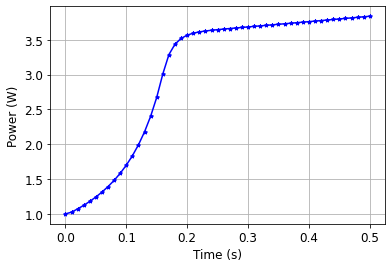

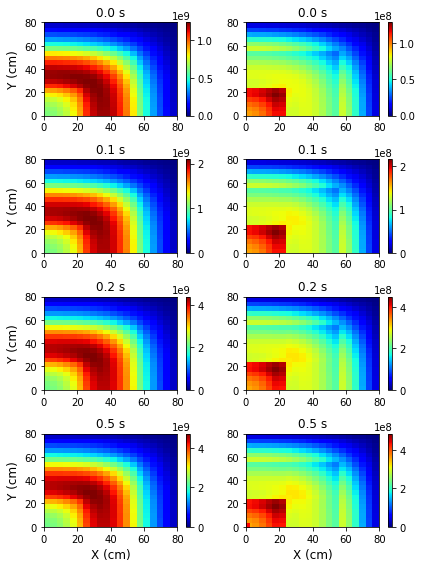

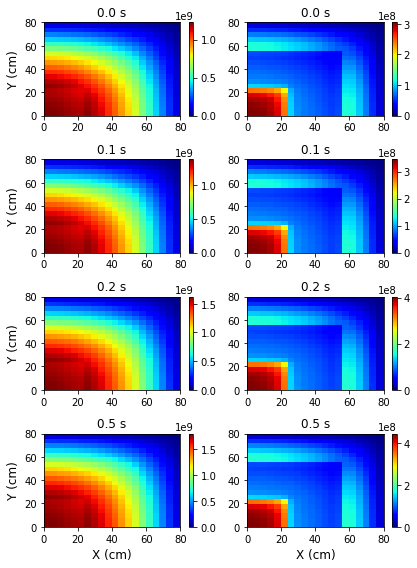

In [35]:

if 'sphere' in problem_name:
    plot_power_span()

    ax = plt.gca()

    if dataset.n_parameters == 1:
        lines = ax.get_lines()
        r_b = dataset.parameters[[0, -1], 0]
        for l, line in enumerate(lines):
            label = "max" if l == 0 else "min"
            line.set_label(fr"$r_{{\{label}}}$")
    ax.set_xlabel("Time ($\mu$s)", fontsize=12)
    ax.tick_params(labelsize=12)
    ax.legend(fontsize=12)
    plt.tight_layout()

elif 'slab' in problem_name:
    plot_power_densities()
    plot_power_span()

elif 'twigl' in problem_name:
    plot_power_span()

elif 'lra' in problem_name:
    plot_power_span(mode=1, logscale='both')
    plot_temperature_span(mode=1)